# The K-profile parameterization in `OceanTurb.jl`

Here we demonstrate how to set up a `Model` in `OceanTurb.jl`, set initial conditions and boundary conditions, and iterate the model forward.

In [1]:
using Pkg; Pkg.activate(".."); Pkg.instantiate()

using OceanTurb, PyPlot, Printf

# A few nice things for plotting
import PyPlot: plot

plot(f::Field, args...; kwargs...) = plot(data(f), nodes(f), args...; kwargs...)
plot(op::Function, f::Field, args...; kwargs...) = plot(op.(data(f)), nodes(f), args...; kwargs...)

"Remove `spine` from `ax`."
function removespine(side, ax=gca())
    ax.spines[side].set_visible(false)
    keywords = Dict(Symbol(side)=>false, Symbol(:label, side)=>false)
    ax.tick_params(keywords)
    nothing
end

removespines(sides...) = for side in sides; removespine(side); end

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


removespines (generic function with 1 method)

# Free convection

Next, we write a function that sets up a 'free convection' problem.

Free convection is characterized

* a constant flux boundary condition for temperature at the top (`buoyancy_flux`)
* a stable, linear temperature initial condition (`γ`)
* zero initial conditions for other variables

In addition, we allow the user to set the resolution, domain size, and model parameters.
We use Backward Euler timestepping.

In [5]:
function free_convection_model(; N=200, L=20, γ=0.01, buoyancy_flux=1e-8, parameters=KPP.Parameters())
    
    model = KPP.Model(N=N, L=L, parameters=parameters, stepper=:BackwardEuler)

    # Initial condition
    γ = 0.01
    T₀(z) = 20 + γ*z
    N₀ = sqrt(model.constants.g*model.constants.α*γ)

    # Set T to the function T0(z)
    model.solution.T = T₀

    temperature_flux = buoyancy_flux / (model.constants.α * model.constants.g)
    model.bcs.T.top = FluxBoundaryCondition(temperature_flux)
    model.bcs.T.bottom = GradientBoundaryCondition(γ)

    # b_t = F_x => F = [m^2 / s^3]; t ~ (F / L^2)^(1/3). F / N^3 = [m^2]
    @printf("""
             buoyancy time-scale: %.2f hours
        10 meter flux time-scale: %.2f hours
    """, 1 / N₀ / 3600, (10^2 / buoyancy_flux)^(1/3) / 3600)
    
    return model
end

free_convection_model (generic function with 1 method)

# The 'Van Roekel' example

[Van Roekel et al (2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018MS001336)
compares the KPP of Large et al. 1994 to a large eddy simulation of free convection with a heat flux of 75 $\mathrm{W \, m^{-2}}$.

They further claim in their equation F11 that in pure convection the mixing layer should deepen according to

$$ h(t) = \sqrt{ \frac{2.8 F_b t}{N^2} } $$

where $F_b$ is the surface buoyancy flux and $N^2 = B_z(t=0)$ is the initial buoyancy gradient.

         buoyancy time-scale: 0.06 hours
    10 meter flux time-scale: 0.36 hours
t: 60.00 minutes, mixing layer depth: 5.42
t: 120.00 minutes, mixing layer depth: 7.22
t: 180.00 minutes, mixing layer depth: 8.58
t: 240.00 minutes, mixing layer depth: 9.74
t: 300.00 minutes, mixing layer depth: 10.75
t: 360.00 minutes, mixing layer depth: 11.67
t: 420.00 minutes, mixing layer depth: 12.52
t: 480.00 minutes, mixing layer depth: 13.31
t: 

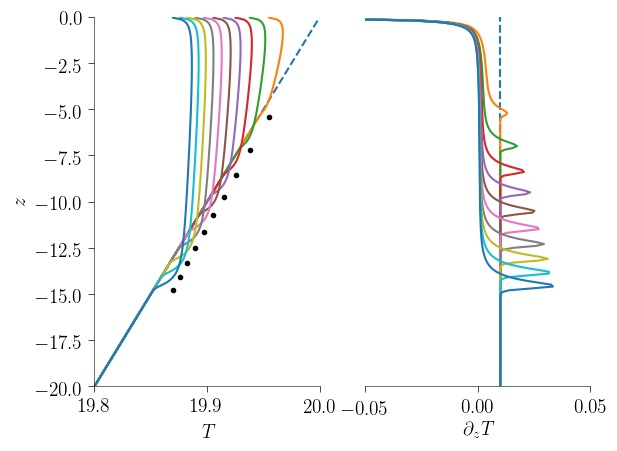

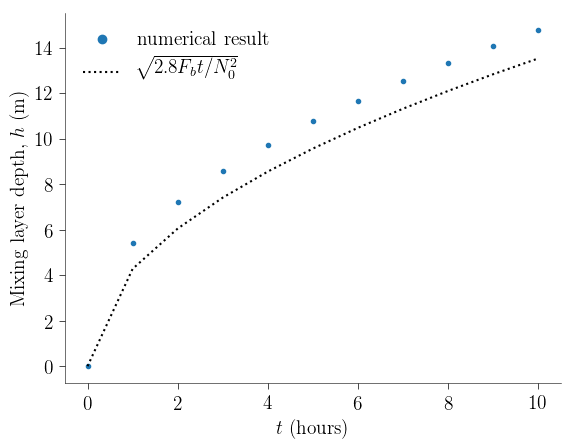

540.00 minutes, mixing layer depth: 14.06
t: 600.00 minutes, mixing layer depth: 14.77


PyObject <matplotlib.legend.Legend object at 0x13d757c88>

In [27]:
# First, let's use the default model
c = OceanTurb.Constants()
heat_flux = 75
v18_buoyancy_flux = c.α * c.g * heat_flux / (c.ρ₀ * c.cP)
model = free_convection_model(buoyancy_flux=v18_buoyancy_flux)

# Time stepping
dt = 60 # seconds
nt = ceil(Int, 3600 / dt) # plot every hour
ni = 10

# Keep track of boundary layer depth versus time
h = [0.0]
t = [0.0]

# Re-initialize plotting and iterating
fig, axs = subplots(ncols=2, sharey=true)

model.solution.T = T₀
U, V, T, S = model.solution
Tz = ∂z(T)
reset!(model.clock)

sca(axs[1])
ylim(-20, 0)
xlim(19.8, 20)
xlabel(L"T")
ylabel(L"z")
removespines("top", "right")

plot(T, "--", label="initial condition")

sca(axs[2])
xlim(-0.05, 0.05)
removespines("left", "top", "right")
axs[2].tick_params(left=false, labelleft=false)
xlabel(L"\partial_z T")

plot(Tz, "--", label="initial condition")

# Iterate
for i = 1:ni
    iterate!(model, dt, nt)
    
    push!(h, model.state.h)
    push!(t, time(model))
    
    @printf("t: %.2f minutes, mixing layer depth: %.2f\n", time(model)/60, model.state.h)
  
    ∂z!(Tz, T)
    
    sca(axs[1])
    plot(T, "-")
    plot(top(T), -model.state.h, "k.")
    
    sca(axs[2])
    plot(Tz, "-")
end

fig, axs= subplots()

removespines("top", "right")
xlabel("\$t\$ (hours)")
ylabel("Mixing layer depth, \$h\$ (m)")

h_vanroekel = sqrt.(2.8*buoyancy_flux/N₀^2 * t)

plot(t/3600, h, ".", label="numerical result")
plot(t/3600, h_vanroekel, "k:", label=L"\sqrt{2.8 F_b t / N_0^2}")

legend()